# 1) Import library yang dibutuhkan

In [1]:
import pickle # Used to save history of training progress
import random
import datetime # Getting timestamp: Used to get date for labelling model using the function ModelCheckpoint
import numpy as np # used for most mathematical operations
import pandas as pd # Used to create a dataframe from detaset for the model
import matplotlib.pyplot as plt # Use for visualization by plotting data or data points
import tensorflow as tf

from keras.models import Sequential
from keras.models import load_model # Used to load pretrained model for testing
from keras.utils import to_categorical # used to label the data
from keras.callbacks import ModelCheckpoint # Used to save best model weights during training process
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam # Model optimizer: Learning rate of 1e-5 is used
from sklearn.model_selection import train_test_split # Used to split data into Training, Validation & Testing
from keras.preprocessing.image import ImageDataGenerator # Used for data augmentation: mainly to reduce within class imbalance to improve accurracy of the model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau # Early stopping helps to stop training when model is no longer learning
from keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Activation # Functions used to build the CNN architecture of the model

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# 2) Mendefinisikan Fungsi

Berikut adalah penjelasan untuk setiap fungsi yang diberikan:

1. **getDataCount(emotion_map=None, data=None):**
   - Fungsi ini menghitung jumlah sampel untuk setiap kategori emosi dalam dataset.
   - `emotion_map`: Pemetaan label emosi ke dalam nama emosi.
   - `data`: DataFrame yang berisi data emosi.

2. **barplot(data=None, emotion_map=None, plt=None, titleType='Emotions'):**
   - Fungsi ini membuat bar plot untuk distribusi kelas dalam dataset.
   - `data`: DataFrame yang berisi data emosi.
   - `emotion_map`: Pemetaan label emosi ke dalam nama emosi.
   - `plt`: Objek matplotlib untuk membuat plot.
   - `titleType`: Tipe judul untuk plot.

3. **plotDatasetSamples(file_path=None, emotion_map=None ,max_num_plot=10):**
   - Fungsi ini memvisualisasikan sampel dataset dengan plot grid.
   - `file_path`: Path ke file CSV yang berisi data gambar.
   - `emotion_map`: Pemetaan label emosi ke dalam nama emosi.
   - `max_num_plot`: Jumlah maksimum sampel yang akan ditampilkan.

4. **downSampleData(data=None, emotion_map=None):**
   - Fungsi ini melakukan downsampling pada dataset untuk menyeimbangkan kelas.
   - `data`: DataFrame yang berisi data emosi.
   - `emotion_map`: Pemetaan label emosi ke dalam nama emosi.

5. **preProcess_augment_oversample(file_path=None, datagen=None, target_samples=None, imbalance_threshold=None):**
   - Fungsi ini melakukan pre-processing, augmentasi data, dan oversampling pada dataset gambar.
   - `file_path`: Path ke file CSV yang berisi data gambar.
   - `datagen`: Objek ImageDataGenerator untuk augmentasi data.
   - `target_samples`: Jumlah target sampel setelah augmentasi.
   - `imbalance_threshold`: Ambang batas ketidakseimbangan kelas untuk oversampling.

6. **create_CNN_model(input_shape=None):**
   - Fungsi ini mendefinisikan arsitektur model CNN menggunakan Keras Sequential.
   - `input_shape`: Bentuk input untuk model.

7. **plotModelHistory(history=None, plt=None):**
   - Fungsi ini memplot grafik histori pelatihan model (akurasi dan loss) dari objek `history` Keras.
   - `history`: Objek histori dari proses pelatihan model.
   - `plt`: Objek matplotlib untuk membuat plot.

8. **plotLoadedModelHistory(history_dict=None, plt=None):**
   - Fungsi ini memplot grafik histori pelatihan model (akurasi dan loss) dari dictionary `history_dict`.
   - `history_dict`: Dictionary yang berisi histori dari proses pelatihan model.
   - `plt`: Objek matplotlib untuk membuat plot.

9. **plotConfusionMatrix(model=None, X_test=None, y_test=None, emotion_map=None, plt=None, np=None):**
   - Fungsi ini memplot matriks kebingungan (confusion matrix) dari model klasifikasi.
   - `model`: Model yang telah dilatih.
   - `X_test`: Data uji untuk evaluasi model.
   - `y_test`: Label yang sebenarnya dari data uji.
   - `emotion_map`: Pemetaan label emosi ke dalam nama emosi.
   - `plt`: Objek matplotlib untuk membuat plot.
   - `np`: Modul NumPy untuk operasi numerik.

10. **plotPredictions(X_test=None, y_test=None,  model=None, plt=None, emotion_map=None, max_num_plot=10 ):**
    - Fungsi ini memplot prediksi model pada beberapa sampel data uji.
    - `X_test`: Data uji untuk evaluasi model.
    - `y_test`: Label yang sebenarnya dari data uji.
    - `model`: Model yang telah dilatih.
    - `plt`: Objek matplotlib untuk membuat plot.
    - `emotion_map`: Pemetaan label emosi ke dalam nama emosi.
    - `max_num_plot`: Jumlah maksimum sampel yang akan ditampilkan.

11. **sampleAugmentationPlotOnly(X_train=None):**
    - Fungsi ini memvisualisasikan contoh augmentasi data untuk gambar.
    - `X_train`: Data latih yang digunakan untuk membuat contoh augmentasi.

Setiap fungsi ini mengambil argumen yang sesuai untuk memanipulasi dan memvisualisasikan data serta model yang terlibat dalam analisis emosi berbasis gambar.

In [3]:
def getDataCount(emotion_map=None, data=None, ):
  emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
  emotion_counts.columns = ['emotion', 'number']
  emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
  return emotion_counts

#*******************************************************************************
def barplot(data=None, emotion_map=None, plt=None, titleType='Emotions'):
    emotion_counts = getDataCount(emotion_map, data=data)
    # print(emotion_counts)
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta']
    plt.figure(figsize=(8, 6))
    bars = plt.bar(emotion_counts['emotion'], emotion_counts['number'], color=colors)
    plt.title('Class Distribution Of '+ titleType)
    plt.xlabel('Emotions')
    plt.ylabel('Number Of Samples')
    plt.xticks(rotation=45)

    for bar, count in zip(bars, emotion_counts['number']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
                ha='center', va='bottom', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

#*******************************************************************************
def plotDatasetSamples(file_path=None, emotion_map=None ,max_num_plot=10):
    if max_num_plot % 3 != 0:
        print(f"'max_num_plot' cannot be odd. Defaulting to max_num_plot = {max_num_plot - 1}")
        max_num_plot = max_num_plot - 1

    df = pd.read_csv(file_path)
    df['pixels'] = df['pixels'].apply(lambda x: [int(p) for p in x.split()])
    df['pixels'] = df['pixels'].apply(lambda x: np.array(x).reshape(48, 48, 1))
    samples = df.sample(max_num_plot)
    samples['emotion_label'] = samples['emotion'].map(emotion_map)

    # Plotting the pixel data
    plt.figure(figsize=(12, 6))
    for i in range(max_num_plot):
        plt.subplot(3, 5, i + 1)
        plt.imshow(samples['pixels'].values[i].reshape(48, 48), cmap='gray')
        plt.title(f"{samples['emotion_label'].values[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#*******************************************************************************
def downSampleData(data=None, emotion_map=None):
    # print('----------------------------------------------\n',data)
    min_count = getDataCount(emotion_map, data=data)['number'].min()
    grouped = data.groupby('emotion')
    down_sampled = grouped.apply(lambda x: x.sample(min_count))
    down_sampled.reset_index(drop=True, inplace=True)
    # print(down_sampled)
    return down_sampled

#*******************************************************************************
from collections import defaultdict

def preProcess_augment_oversample(file_path=None, datagen=None, target_samples=None, imbalance_threshold=None):
    # Part 1: Pre-processing
    df = pd.read_csv(file_path)
    df['pixels'] = df['pixels'].apply(lambda x: [int(p) for p in x.split()])  # Convert strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: np.array(x).reshape(48, 48, 1))  # Reshape to 48x48x1
    df['pixels'] = df['pixels'] / 255.0  # Normalisation

    data = np.array(df['pixels'].tolist())
    labels = np.array(df['emotion'])

    if imbalance_threshold:
          # Calculate class counts
          class_counts = defaultdict(list)
          for idx, label in enumerate(labels):
              class_counts[label].append(idx)

          # Determine classes below and above threshold
          minority_classes = [label for label, idxs in class_counts.items() if len(idxs) < imbalance_threshold]
          majority_classes = [label for label, idxs in class_counts.items() if len(idxs) >= imbalance_threshold]

          # Oversampling minority classes below threshold
          oversampled_data = []
          oversampled_labels = []
          for label in minority_classes:
              indices = class_counts[label]
              num_to_generate = imbalance_threshold - len(indices)
              if num_to_generate > 0:
                  for idx in np.random.choice(indices, num_to_generate, replace=True):
                      augmented_x = datagen.random_transform(data[idx])
                      oversampled_data.append(augmented_x)
                      oversampled_labels.append(labels[idx])

          # Downsampling majority classes above threshold
          downsampled_data = []
          downsampled_labels = []
          for label in majority_classes:
              indices = class_counts[label]
              num_to_keep = imbalance_threshold
              if num_to_keep > 0:
                  sampled_indices = np.random.choice(indices, num_to_keep, replace=False)
                  for idx in sampled_indices:
                      downsampled_data.append(data[idx])
                      downsampled_labels.append(labels[idx])

          # Combine oversampled and downsampled data
          if oversampled_data:
              data = np.concatenate((data, oversampled_data), axis=0)
              labels = np.concatenate((labels, oversampled_labels), axis=0)

          if downsampled_data:
              data = np.concatenate((data, downsampled_data), axis=0)
              labels = np.concatenate((labels, downsampled_labels), axis=0)

    # Part 2: Augmentation
    expanded_data = []
    expanded_labels = []
    if target_samples is None:
      expanded_data=data
      expanded_labels=labels
    else:
      for x, y in zip(data, labels):
          expanded_data.append(x)
          expanded_labels.append(y)

          # Augmentation and adding the augmented image
          if target_samples:
              for i in range(target_samples):
                  augmented_x = datagen.random_transform(x)
                  expanded_data.append(augmented_x)
                  expanded_labels.append(y)

    expanded_data = np.array(expanded_data)
    expanded_labels = np.array(expanded_labels)

    # Part 3: Splitting dataset
    X_train, X_test, y_train, y_test = train_test_split(expanded_data, expanded_labels, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Part 4: Convert integer labels to one-hot encoded format
    y_train = to_categorical(y_train, num_classes=7)  # for 7 classes
    y_val = to_categorical(y_val, num_classes=7)
    y_test = to_categorical(y_test, num_classes=7)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

#*******************************************************************************
def create_CNN_model(input_shape=None):
    if input_shape is None:
        input_shape = (48, 48, 1)

    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # GlobalAveragePooling2D layer before fully connected layers
    model.add(GlobalAveragePooling2D())

    # Fully connected layers
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(7))
    model.add(Activation('softmax'))

    return model

#*******************************************************************************
def plotModelHistory(history=None, plt=None):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    axs[0].grid(True)
    # history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    axs[1].grid(True)
    plt.show()

#*******************************************************************************
def plotLoadedModelHistory(history_dict=None, plt=None):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # history for accuracy
    axs[0].plot(history_dict['accuracy'])
    axs[0].plot(history_dict['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')
    axs[0].grid(True)

    # history for loss
    axs[1].plot(history_dict['loss'])
    axs[1].plot(history_dict['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')
    axs[1].grid(True)
    plt.show()

#*********************************************************************************
def plotConfusionMatrix(model=None, X_test=None, y_test=None, emotion_map=None, plt=None, np=None):
  # predictions of model
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  # Compute confusion matrix
  conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

  # Plot confusion matrix using Matplotlib
  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
  plt.colorbar()
  # Set tick marks and labels
  tick_marks = np.arange(len(emotion_map))
  plt.xticks(tick_marks, emotion_map.values(), rotation=45)
  plt.yticks(tick_marks, emotion_map.values())

  for i in range(len(emotion_map)):
      for j in range(len(emotion_map)):
          plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')

  plt.tight_layout()
  plt.show()

#*******************************************************************************
def plotPredictions(X_test=None, y_test=None,  model=None, plt=None, emotion_map=None, max_num_plot=10 ):
  if max_num_plot % 3 != 0:
    print(f"'max_num_plot' cannot be old. Defaulting to max_num_plot= {max_num_plot} -1 = {max_num_plot-1}")
    max_num_plot = max_num_plot- 1

  predictions = model.predict(X_test)
  predicted_labels = np.argmax(predictions, axis=1)

  # Calculate accuracy
  correct_predictions = np.equal(predicted_labels, np.argmax(y_test, axis=1))
  accuracy = np.mean(correct_predictions)
  print(f"Test Accuracy: {accuracy * 100:.2f}%")

  # Create a list of emotions from the predicted labels using the emotion_map
  predicted_emotions = [emotion_map[label] for label in predicted_labels]
  actual_emotions = [emotion_map[label] for label in np.argmax(y_test, axis=1)]


  plt.figure(figsize=(12, 6))
  for i in range(1,max_num_plot+1):
      plt.subplot(3, max_num_plot // 3, i)
      plt.imshow(X_test[i].reshape(48, 48), cmap='gray')
      plt.title(f"Actual: {actual_emotions[i]}\nPredicted: {predicted_emotions[i]}",fontsize=8)
      plt.axis('off')

  plt.tight_layout()
  plt.show()

#*******************************************************************************
def sampleAugmentationPlotOnly(X_train=None):
  rotate_datagen = ImageDataGenerator(vertical_flip=True, fill_mode='nearest')  # Rotate images by up to angle = 40 degrees
  horizontal_flip = ImageDataGenerator(horizontal_flip=True,fill_mode='nearest')  # Flip images horizontally
  datagen = [rotate_datagen, horizontal_flip]
  aug_titles = ["Vertical flip Augmentation", "Horizontal flip Augmentation"]

  # Create a figure with two rows and two columns of subplots
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))
  index = random.randint(0, len(X_train) - 1)  # Choose a random image index
  for i in range(2):
      augmented_image = datagen[i].random_transform(X_train[index])  # Augment a random image
      # Plot the original image
      axs[i, 0].imshow(X_train[index], cmap='gray')  # Force grayscale interpretation
      axs[i, 0].set_title("Original Image")
      axs[i, 0].axis('off')  # Remove axis numbering (ticks)
      # Plot the augmented image
      axs[i, 1].imshow(augmented_image, cmap='gray')  # Force grayscale interpretation
      axs[i, 1].set_title(aug_titles[i])
      axs[i, 1].axis('off')  # Remove axis numbering (ticks)
  plt.show()

# 3) Dataset

In [4]:
working_dir = 'C:\Skripsi/Enhancing-FER2013-Imbalance-main/Enhancing-FER2013-Imbalance-main/'

In [5]:
df = pd.read_csv(working_dir+'fer2013.csv')
print(df.head())
print(df.describe())


   emotion                                             pixels
0        0  46 34 26 23 12 32 35 26 26 38 71 99 123 134 14...
1        0  55 33 54 32 26 21 50 29 38 45 79 73 43 22 51 5...
2        0  123 123 126 131 124 69 109 149 159 174 169 178...
3        0  255 255 255 255 255 255 255 255 255 251 254 16...
4        0  127 121 124 137 123 118 120 111 111 109 118 14...
            emotion
count  35887.000000
mean       3.323265
std        1.873819
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        6.000000


Visualisasi data dan label

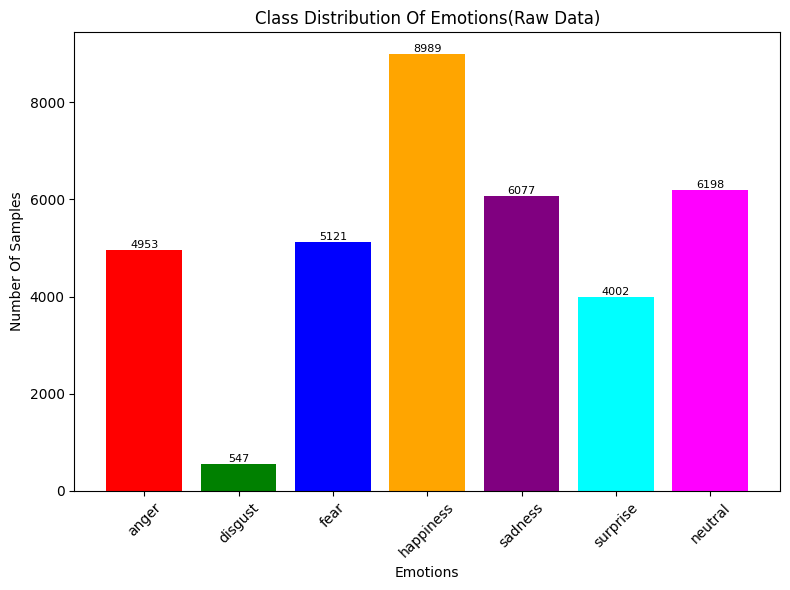

In [6]:
emotion_map = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
barplot(data=df,
        emotion_map=emotion_map,
        plt=plt,
        titleType='Emotions(Raw Data)')

del df

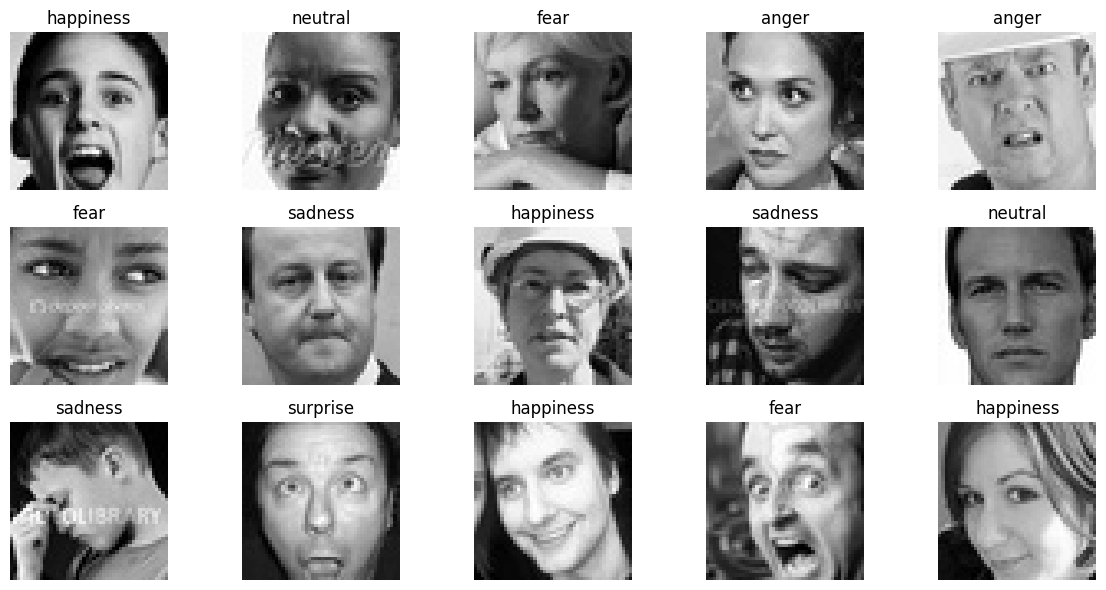

In [7]:
plotDatasetSamples(file_path=working_dir+'fer2013.csv',
                   emotion_map=emotion_map,
                   max_num_plot=15
                   )


# 4) Data Pre-processing
**Langkah-langkah:**
- Memisahkan dataset menjadi 3 bagian: Pelatihan: **80%**, Validasi: **10%**, dan Pengujian: **10%** (Bagian 3 dari `preProcess_augment_oversample()`)
- Mengubah string menjadi daftar bilangan bulat: (Bagian 1 dari `preProcess_augment_oversample()`)
- Mereshape menjadi 48x48x1 dan normalisasi gambar skala abu-abu: (Bagian 1 dari `preProcess_augment_oversample()`)
- Melakukan enkoding one-hot label, misalnya kelas 3 menjadi [0,0,0,1,0,0,0]: (Bagian 4 dari `preProcess_augment_oversample()`)
- Oversampling kelas minoritas: `preProcess_augment_oversample()`
- Augmentasi data: `preProcess_augment_oversample()`

In [8]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest' # determines how empty pixels(if available) are filled based on the nearest available pixel values, during  image transformation
                             )
imbalance_threshold = 5121
(X_train, y_train), (X_val, y_val), (X_test, y_test) = preProcess_augment_oversample(
    file_path=working_dir+'fer2013.csv',
    datagen=datagen,
    target_samples=1,
    imbalance_threshold=imbalance_threshold
    )
X_train.shape, X_val.shape, X_test.shape

((99571, 48, 48, 1), (12446, 48, 48, 1), (12447, 48, 48, 1))

Sample Augmentation

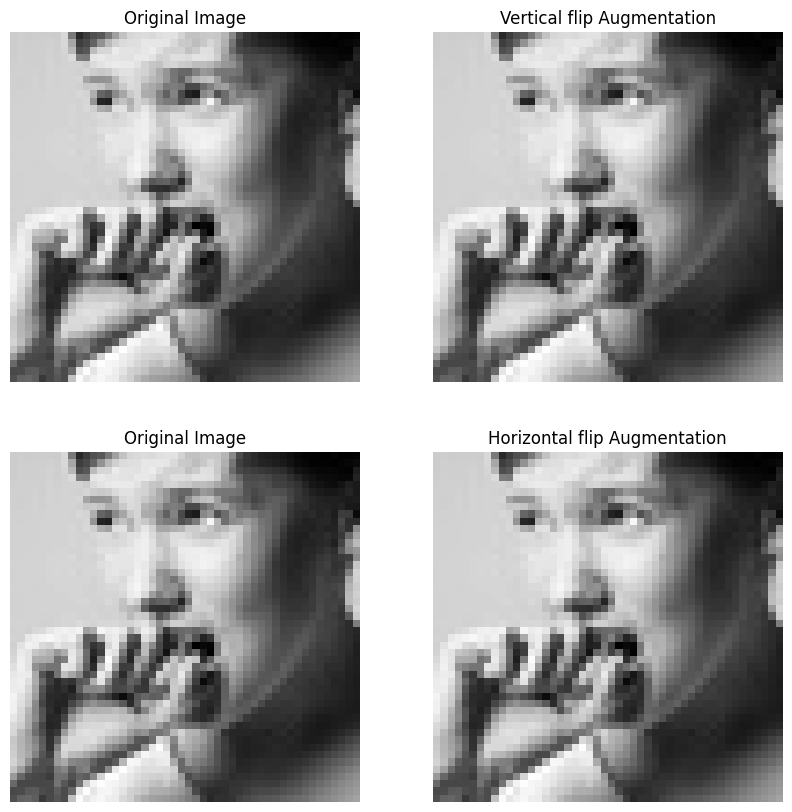

In [9]:
sampleAugmentationPlotOnly(X_train=X_train)

# 5) CNN Architecture

 - `create_CNN_model()`



In [10]:
model =create_CNN_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0         
                                                                 
 dropout (Dropout)           (None, 46, 46, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 activation_2 (Activation)   (None, 46, 46, 128)       

# 6) Training

**Callbacks**
- `ModelCheckpoint()`: Used to save best model weights during training process
- `EarlyStopping()`:  Early stopping helps to stop training when model is no longer learning

In [11]:
current_time = datetime.datetime.now()
checkpoint_path = working_dir+f'checkpoint/best_model_experiment3_{str(current_time).split(" ")[0]}.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')  # 'max' if monitoring accuracy, 'min' if monitoring loss

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

**Compile dan Train Model**

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    batch_size=32,
                    epochs=10000,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, checkpoint],
                    verbose=1,
                    )

Epoch 1/10000


3112/3112 [==============================] - ETA: 0s - loss: 1.8624 - accuracy: 0.2248
Epoch 1: val_accuracy improved from -inf to 0.23357, saving model to C:\Skripsi/Enhancing-FER2013-Imbalance-main/Enhancing-FER2013-Imbalance-main/checkpoint\best_model_experiment3_2024-07-01.h5


c:\Users\wilbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3112/3112 [==============================] - 3201s 1s/step - loss: 1.8624 - accuracy: 0.2248 - val_loss: 1.8422 - val_accuracy: 0.2336
Epoch 2/10000
3112/3112 [==============================] - ETA: 0s - loss: 1.8364 - accuracy: 0.2445
Epoch 2: val_accuracy improved from 0.23357 to 0.25012, saving model to C:\Skripsi/Enhancing-FER2013-Imbalance-main/Enhancing-FER2013-Imbalance-main/checkpoint\best_model_experiment3_2024-07-01.h5
3112/3112 [==============================] - 3127s 1s/step - loss: 1.8364 - accuracy: 0.2445 - val_loss: 1.8224 - val_accuracy: 0.2501
Epoch 3/10000
3112/3112 [==============================] - ETA: 0s - loss: 1.8264 - accuracy: 0.2544
Epoch 3: val_accuracy improved from 0.25012 to 0.25366, saving model to C:\Skripsi/Enhancing-FER2013-Imbalance-main/Enhancing-FER2013-Imbalance-main/checkpoint\best_model_experiment3_2024-07-01.h5
3112/3112 [==============================] - 3124s 1s/step - loss: 1.8264 - accuracy: 0.2544 - val_loss: 1.8195 - val_accuracy: 0.2537

**Save the training history dictionary**

In [13]:
history_path = working_dir+f'checkpoint/experiment3_best_model_history.pkl'

with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)


**Visualisasi Performa Model**

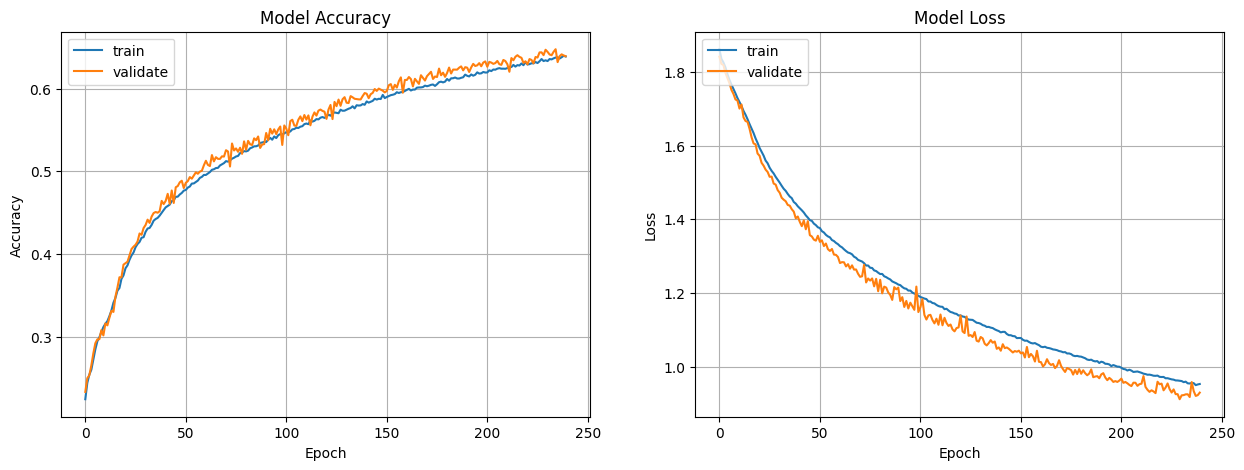

In [14]:
plotModelHistory(history=history, plt=plt)

# 7) Test Model yang Sudah Dilatih

In [15]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

389/389 [==============================] - 21s 53ms/step - loss: 0.8788 - accuracy: 0.6643
Test loss: 0.8787642121315002
Test accuracy: 0.6642564535140991


**Confusion Matrix**

389/389 [==============================] - 22s 55ms/step


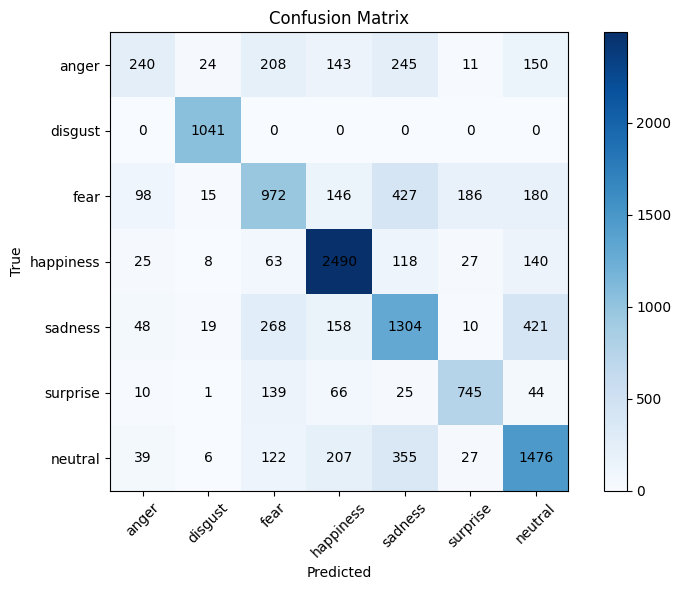

In [16]:
plotConfusionMatrix(model=model,
                    X_test=X_test,
                    y_test=y_test,
                    emotion_map=emotion_map,
                    plt=plt,
                    np=np
                    )

389/389 [==============================] - 24s 61ms/step
Test Accuracy: 66.43%


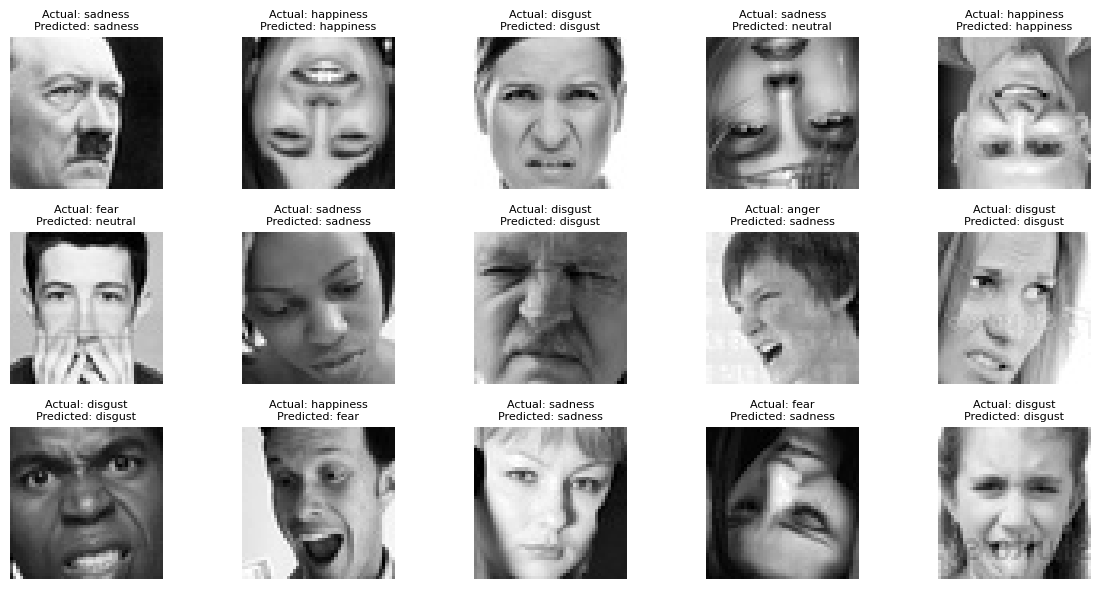

In [17]:
plotPredictions(X_test=X_test,
                y_test=y_test,
                model=model,
                plt=plt,
                emotion_map=emotion_map,
                max_num_plot = 15 )

# 8) Tesing menggunakan Model yang Telah Disimpan

In [18]:
emotion_map = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
datagen = ImageDataGenerator(horizontal_flip=True,
                             fill_mode='nearest' # determines how empty pixels(if available) are filled based on the nearest available pixel values, during  image transformation
                             )

# imbalance_threshold = 547
# (X_train, y_train), (X_val, y_val), (X_test, y_test) = preProcess_augment_oversample(
#     file_path=working_dir+'fer2013.csv',
#     datagen=datagen,
#     target_samples=None,
#     imbalance_threshold=imbalance_threshold
#     )
# X_train.shape, X_val.shape, X_test.shape

In [19]:
import os
os.listdir(working_dir+'checkpoint')

['best_model_experiment1_2024-07-01.h5',
 'best_model_experiment2_2024-07-01.h5',
 'best_model_experiment3_2024-07-01.h5',
 'best_model_experiment4_2024-06-27.h5',
 'best_model_experiment5_2024-06-27.h5',
 'best_model_experiment6_2024-06-27.h5',
 'best_model_experiment6_2024-06-29.h5',
 'best_model_experiment6_2024-07-01.h5',
 'experiment1_best_model_history.pkl',
 'experiment2_best_model_history.pkl',
 'experiment3_best_model_history.pkl',
 'experiment4_best_model_history.pkl',
 'experiment5_best_model_history.pkl',
 'experiment6_best_model_history.pkl']

In [20]:
loaded_model = load_model(working_dir+'checkpoint/best_model_2024-04-23.h5', {'Activation': Activation} )

OSError: No file or directory found at C:\Skripsi/Enhancing-FER2013-Imbalance-main/Enhancing-FER2013-Imbalance-main/checkpoint/best_model_2024-04-23.h5

**Visualisasi Performa CNN Model (load model)**

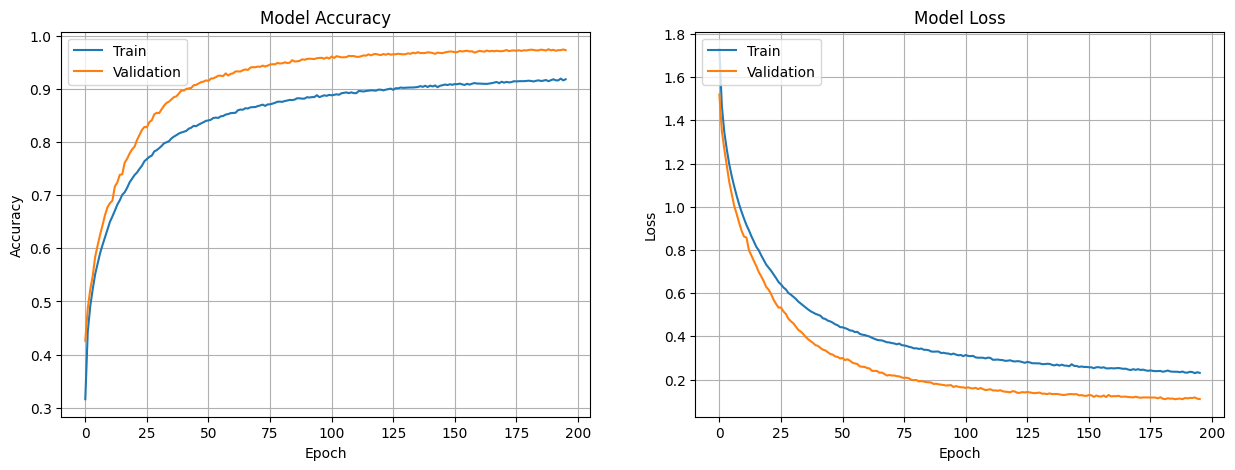

In [ ]:
history_path= working_dir + "checkpoint/best_model_history.pkl"
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)

plotLoadedModelHistory(history_dict=loaded_history, plt=plt)

In [ ]:
loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss}")


389/389 [==============================] - 3s 8ms/step - loss: 2.5430 - accuracy: 0.7784
Test Accuracy: 77.84%
Test Loss: 2.54301118850708


**Confusion Matrix**

389/389 [==============================] - 3s 8ms/step


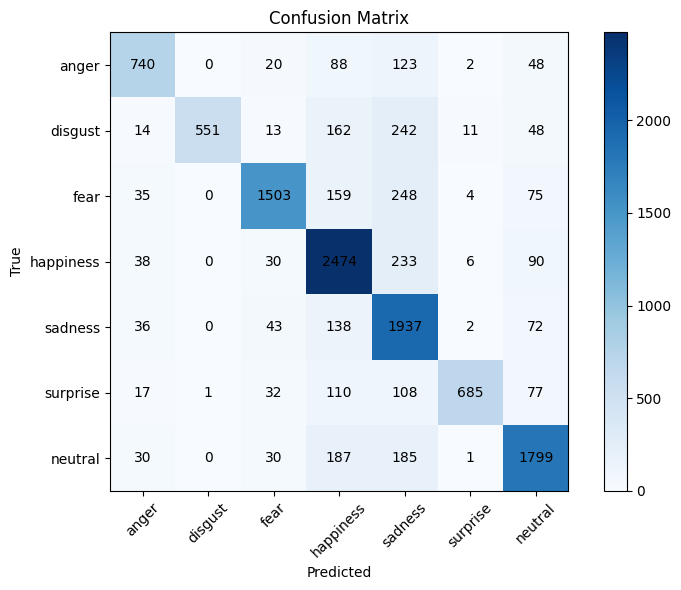

In [ ]:
plotConfusionMatrix(model=loaded_model,
                    X_test=X_test,
                    y_test=y_test,
                    emotion_map=emotion_map,
                    plt=plt,
                    np=np
                    )

389/389 [==============================] - 3s 8ms/step
Test Accuracy: 77.84%


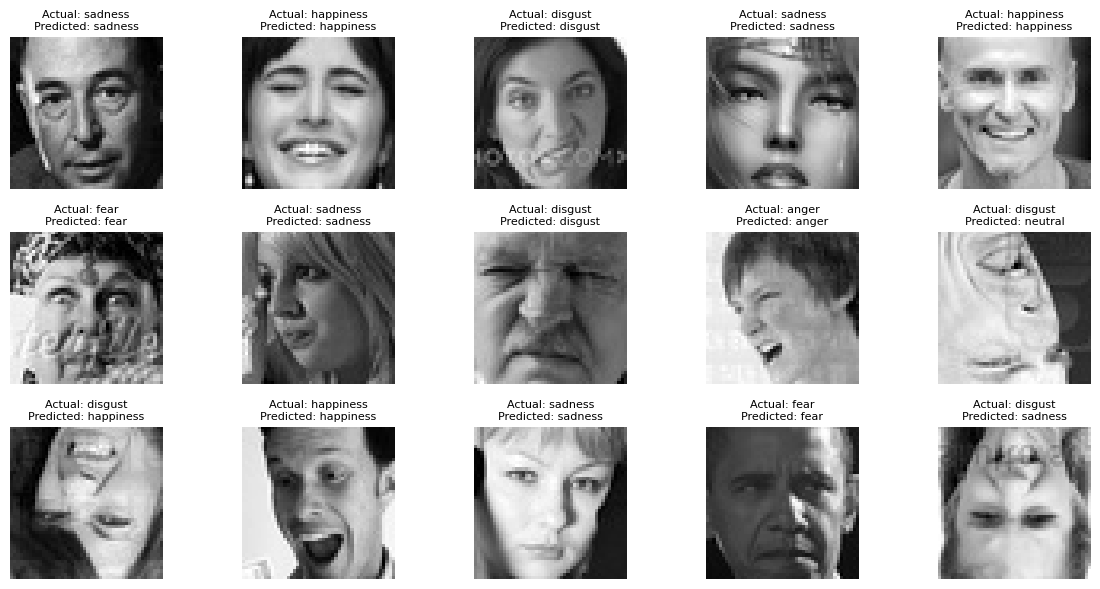

: 

In [ ]:
plotPredictions(X_test=X_test,
                y_test=y_test,
                model=loaded_model,
                plt=plt,
                emotion_map=emotion_map,
                max_num_plot = 15 )

# END